# Eksploracyjna analiza danych

## Importowanie bibliotek

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

sns.set_theme()

## Wczytywanie danych

In [15]:
path = "../working/data/raw/sales_ads_train.csv"
df = pd.read_csv(path)
path = "../working/data/raw/sales_ads_test.csv"
df_test = pd.read_csv(path)

In [17]:
len(df.columns)

25

In [16]:
df.isnull().sum()

ID                                0
Cena                              0
Waluta                         3376
Stan                           3322
Marka_pojazdu                  3351
Model_pojazdu                  3309
Wersja_pojazdu                48061
Generacja_pojazdu             41660
Rok_produkcji                  3407
Przebieg_km                    4003
Moc_KM                         3733
Pojemnosc_cm3                  4686
Rodzaj_paliwa                  3410
Emisja_CO2                    75900
Naped                         13054
Skrzynia_biegow                3775
Typ_nadwozia                   3359
Liczba_drzwi                   4364
Kolor                          3463
Kraj_pochodzenia              60420
Pierwszy_wlasciciel           94514
Data_pierwszej_rejestracji    80698
Data_publikacji_oferty         3449
Lokalizacja_oferty             3341
Wyposazenie                    3253
dtype: int64

In [19]:
df["Model_pojazdu"].nunique()

1139

## Wizualizacje

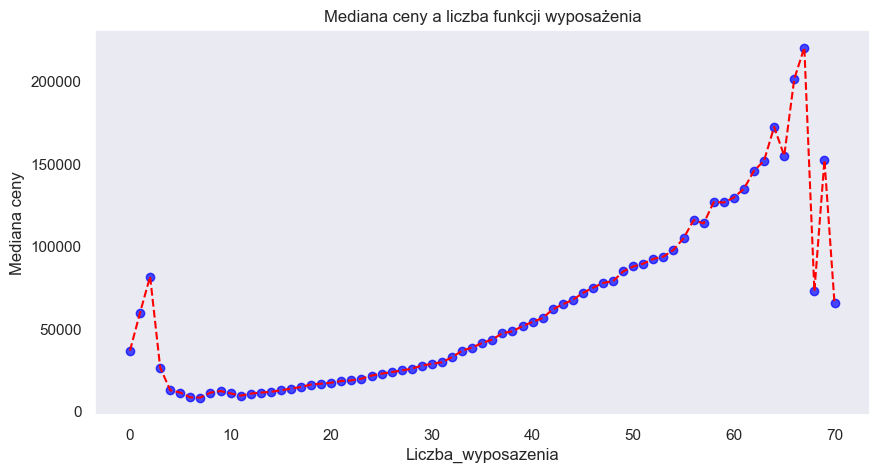

In [3]:
def count_equipment(equipment_str):
    try:
        equipment_list = ast.literal_eval(equipment_str)  
        if isinstance(equipment_list, list):
            return len(equipment_list)  
    except (SyntaxError, ValueError):
        return 0  
    return 0

df["Liczba_wyposazenia"] = df["Wyposazenie"].apply(count_equipment)
median_prices = df.groupby("Liczba_wyposazenia")["Cena"].median().reset_index()
plt.figure(figsize=(10, 5))
plt.scatter(median_prices["Liczba_wyposazenia"], median_prices["Cena"], alpha=0.7, color="blue")
plt.plot(median_prices["Liczba_wyposazenia"], median_prices["Cena"], linestyle='--', color='red')  # Add trendline
plt.xlabel("Liczba_wyposazenia")
plt.ylabel("Mediana ceny")
plt.title("Mediana ceny a liczba funkcji wyposażenia")
plt.grid()
plt.show()

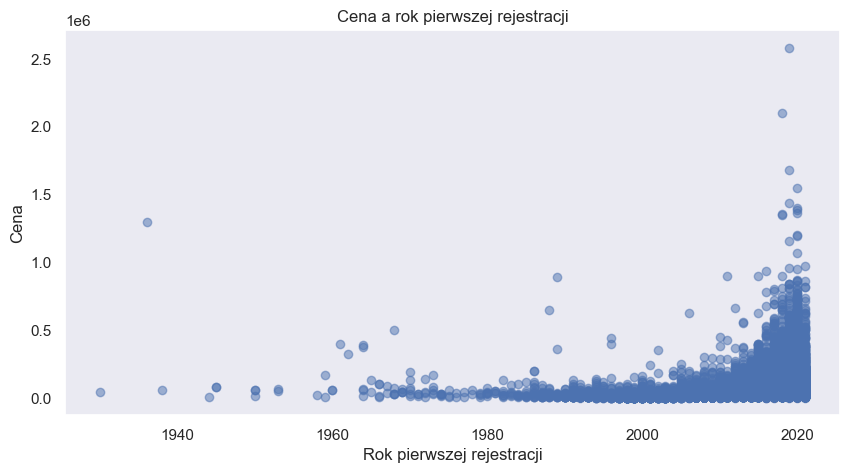

In [32]:
df["Data_pierwszej_rejestracji"] = pd.to_datetime(df["Data_pierwszej_rejestracji"], errors="coerce", dayfirst=True)
df["rok_rejestracji"] = df["Data_pierwszej_rejestracji"].dt.year
df = df[(df["rok_rejestracji"] <= 2021) & (df["rok_rejestracji"] >= 1930)]
plt.figure(figsize=(10, 5))
plt.scatter(df["rok_rejestracji"], df["Cena"], alpha=0.5)
plt.xlabel("Rok pierwszej rejestracji")
plt.ylabel("Cena")
plt.title("Cena a rok pierwszej rejestracji")
plt.grid()
plt.show()

In [4]:
def make_price_average_chart(df, column, xlabel):
    avg_price = df.groupby(column)['Cena'].mean()
    plt.figure(figsize=(10, 5))
    avg_price.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel(xlabel)
    plt.ylabel("Średnia cena")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

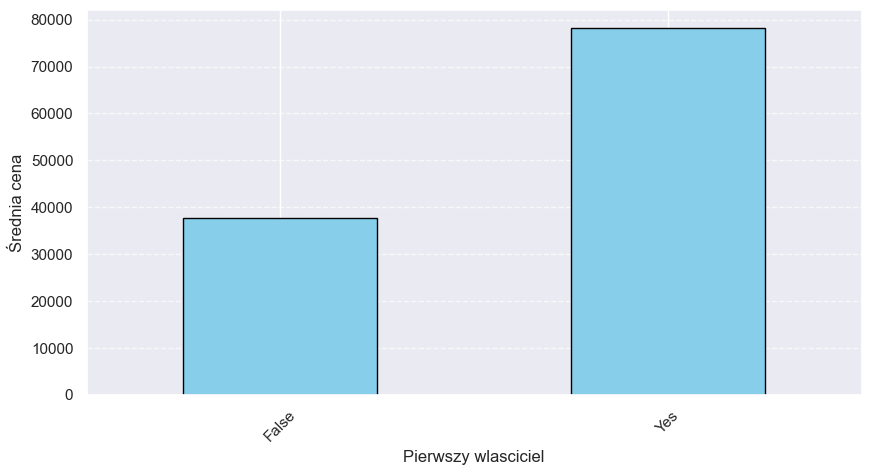

In [34]:
df["wlasciciel_bin"] = df["Pierwszy_wlasciciel"].apply(lambda x: False if pd.isnull(x) else x)
make_price_average_chart(df, 'wlasciciel_bin', "Pierwszy wlasciciel")

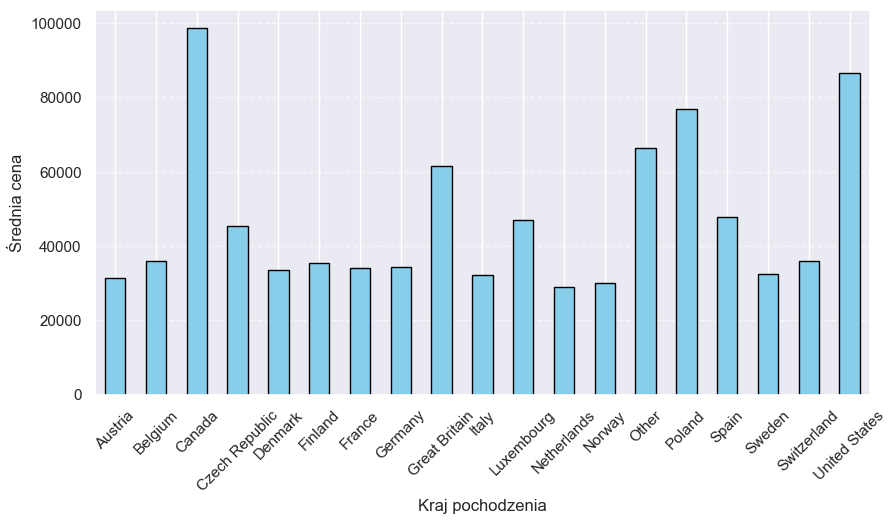

In [35]:
df_popular_countries = df.groupby("Kraj_pochodzenia").filter(lambda x: len(x) >= 15)
make_price_average_chart(df_popular_countries, 'Kraj_pochodzenia', "Kraj pochodzenia")

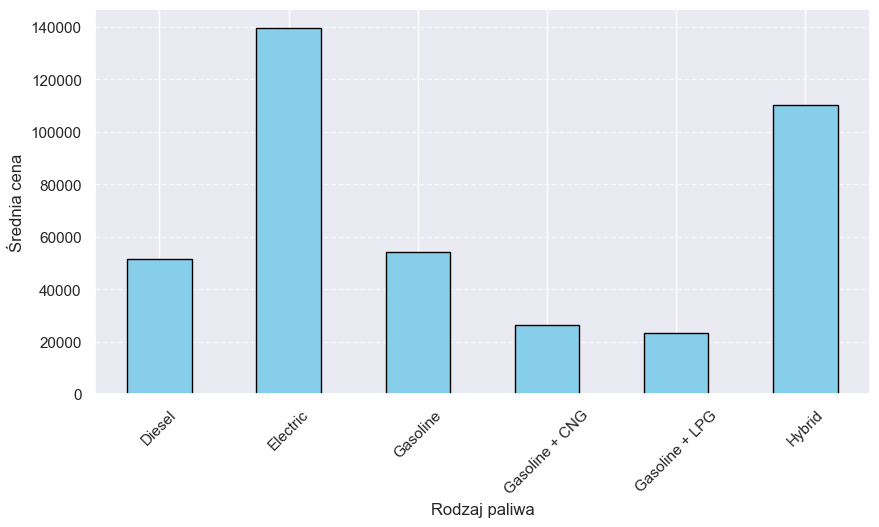

In [36]:
test_set_fuel = df_test["Rodzaj_paliwa"].unique()
df_fuel = df[df["Rodzaj_paliwa"].isin(test_set_fuel)]
make_price_average_chart(df_fuel, 'Rodzaj_paliwa', "Rodzaj paliwa")

Zbiór testowy nie zawiera wszystkich rodzajów paliwa ze zbioru treningowego.

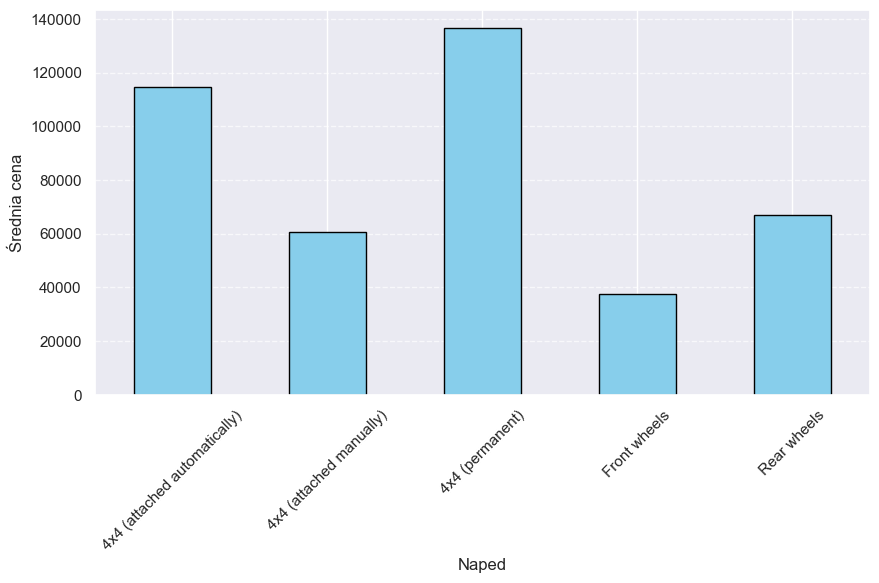

In [37]:
make_price_average_chart(df, 'Naped', "Naped")

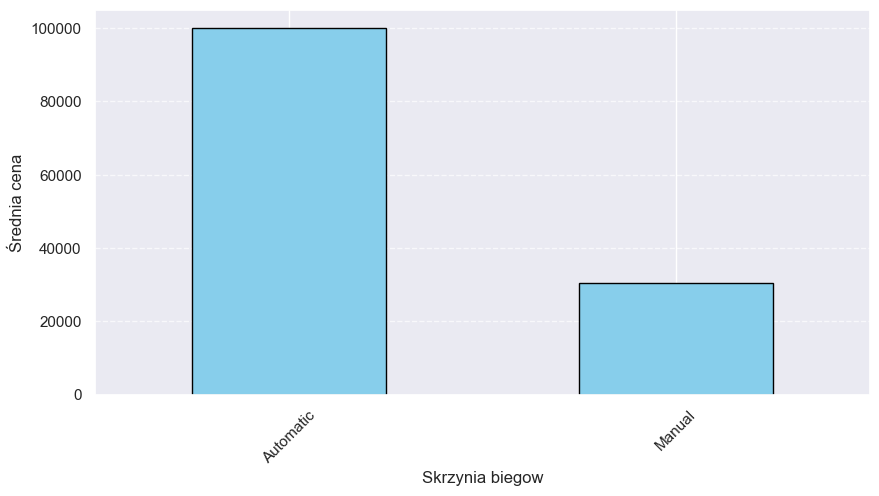

In [38]:
make_price_average_chart(df, 'Skrzynia_biegow', "Skrzynia biegow")

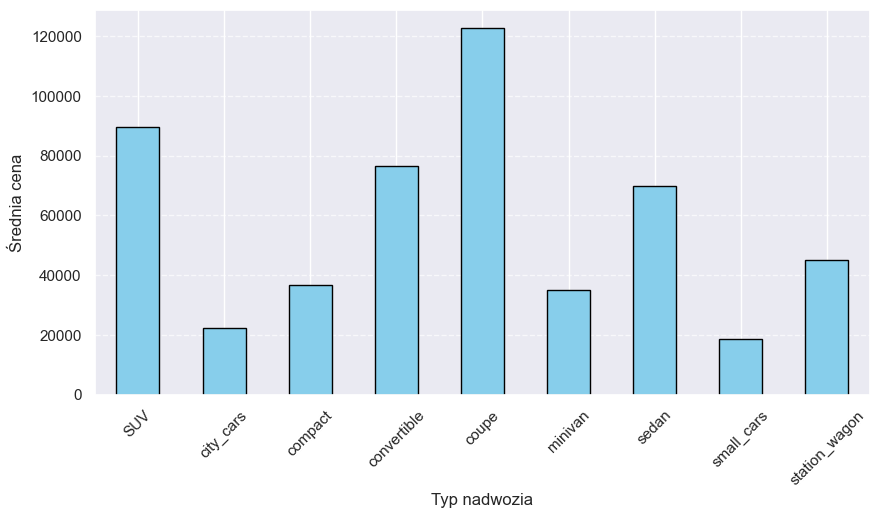

In [40]:
make_price_average_chart(df, 'Typ_nadwozia', "Typ nadwozia")

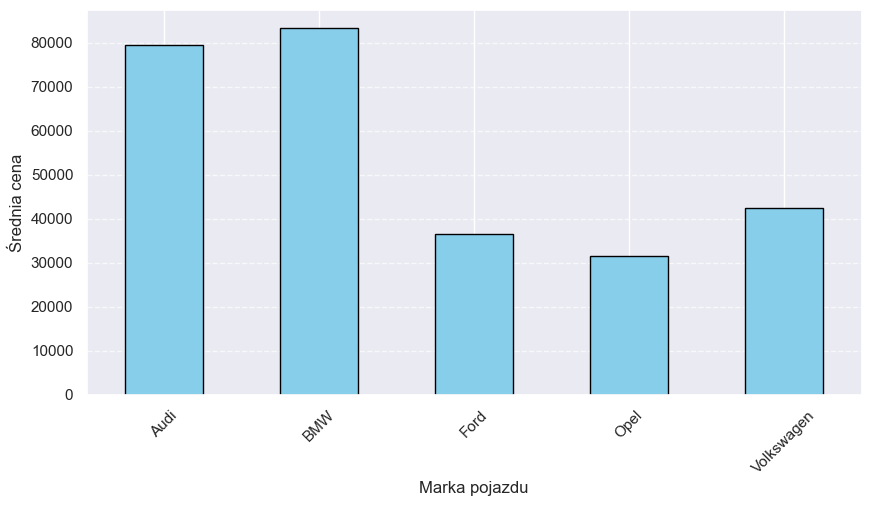

In [42]:
top_marks = df['Marka_pojazdu'].value_counts().head().index
filtered_df = df[df['Marka_pojazdu'].isin(top_marks)]
make_price_average_chart(filtered_df, 'Marka_pojazdu', "Marka pojazdu")

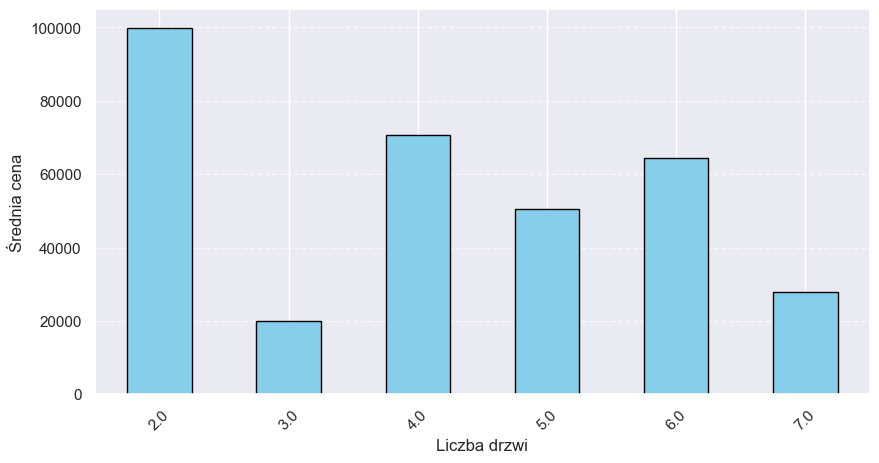

In [44]:
test_set_doors = df_test["Liczba_drzwi"].unique()
df_door = df[df["Liczba_drzwi"].isin(test_set_doors)]
make_price_average_chart(df_door, 'Liczba_drzwi', "Liczba drzwi")

Dane dotyczące 55 i 1 drzwi były błędne, dlatego zostały przefiltrowane.

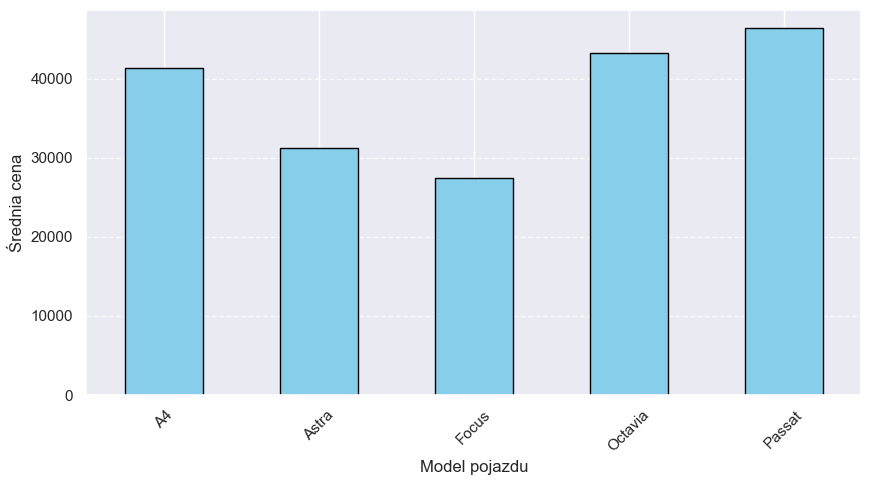

In [46]:
top_models = df['Model_pojazdu'].value_counts().head().index
filtered_df = df[df['Model_pojazdu'].isin(top_models)]
make_price_average_chart(filtered_df, 'Model_pojazdu', "Model pojazdu")

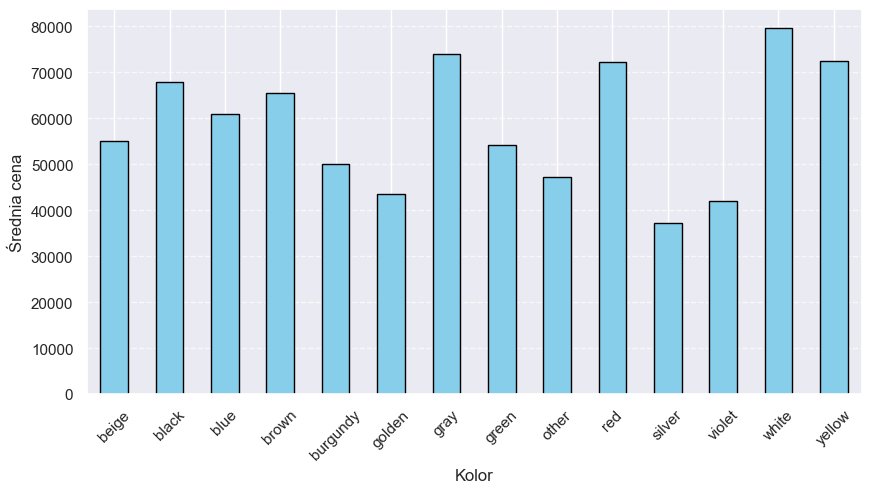

In [8]:
df_popular_colors = df.groupby("Kolor").filter(lambda x: len(x) >= 100)
make_price_average_chart(df_popular_colors, 'Kolor', "Kolor")

Waluta
PLN    131856
EUR       165
Name: count, dtype: int64

## Dodatkowe dane

In [13]:
train_currency = df['Waluta'].value_counts()
test_currency = df_test['Waluta'].value_counts()
train_currency, test_currency

(Waluta
 PLN    131856
 EUR       165
 Name: count, dtype: int64,
 Waluta
 PLN    72808
 EUR       99
 Name: count, dtype: int64)

## Wnioski

Na podstawie eksploracyjnej analizy danych można wywnioskować, że spośród 24 cech jedynie **ID** nie niesie użytecznej informacji. Nawet **kolor** pojazdu, jak wynika z wykresów, pomaga w przewidywaniu ceny.

Wiele cech wykazuje zależność eksponencjalną względem ceny (np. rok pierwszej rejestracji), dlatego przydatne będzie logarytmiczne przekształcenie tych zmiennych.
Niektóre cechy zawierają dużą liczbę nieprawidłowych wartości i wymagają odpowiedniego przekształcenia w celu wydobycia istotnych informacji. Na przykład z daty pierwszej rejestracji należy wyodrębnić sam rok.

**Wyposazenie** zawiera złożone dane w postaci list, dlatego wymaga innego podejścia do przekształcenia. Można na przykład wyodrębnić liczbę elementów w liście lub sprawdzić, czy zawiera ona elementy charakterystyczne dla luksusowych samochodów.

Niektóre cechy, takie jak **Model_pojazdu**, zawierają dużą liczbę unikalnych kategorii. W takim przypadku przed utworzeniem zmiennych zero-jedynkowych (dummy variables) warto pogrupować dane.